<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           1251 non-null   object
 1   meta           1251 non-null   object
 2   _input_hash    1251 non-null   int64 
 3   _task_hash     1251 non-null   int64 
 4   _is_binary     1251 non-null   bool  
 5   tokens         1251 non-null   object
 6   _view_id       1251 non-null   object
 7   spans          468 non-null    object
 8   answer         1251 non-null   object
 9   _timestamp     1251 non-null   int64 
 10  _annotator_id  1251 non-null   object
 11  _session_id    1251 non-null   object
dtypes: bool(1), int64(3), object(8)
memory usage: 108.9+ KB
None
                                                text  \
0  The Justice Department issued the following st...   
1  “The country woke up this morning to news of a...   
2  My heart is broken for those who began their y...   
3

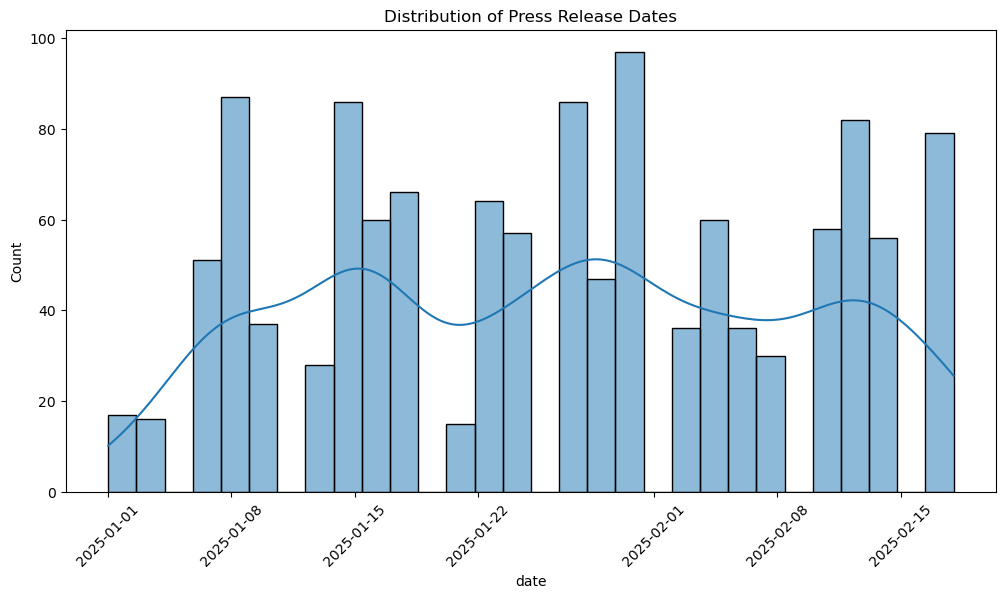

No 'entities' column found; skipping entity analysis.


In [1]:
# 01-exploration.ipynb

import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Load the raw data
data_path = '../data/raw/doj_press_releases.jsonl'

def load_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f if line.strip()]

press_releases = load_data(data_path)

# Convert to DataFrame for analysis
df = pd.DataFrame(press_releases)

# Display basic information about the dataset
print(df.info())
print(df.head())

print("records:", len(press_releases))
if press_releases:
    print("sample record keys/value preview:")
    pprint.pprint({k: press_releases[0].get(k) for k in list(press_releases[0])[:10]})

print("DataFrame columns:", df.columns.tolist())

# find date-like candidates
candidates = [c for c in df.columns if 'date' in c.lower() or 'press' in c.lower()]
if not candidates and 'meta' in df.columns:
    # try common nested meta keys
    df['meta_press_release_date'] = df['meta'].apply(lambda m: m.get('press_release_date') if isinstance(m, dict) else None)
    df['meta_date'] = df['meta'].apply(lambda m: m.get('date') if isinstance(m, dict) else None)
    candidates += [c for c in ['meta_press_release_date', 'meta_date'] if c in df.columns]

print("date-like candidates:", candidates)

# parse the first usable candidate into df['date']
df['date'] = pd.NaT
for c in candidates:
    parsed = pd.to_datetime(df[c], errors='coerce')
    if parsed.notna().sum() > 0:
        df['date'] = parsed
        print(f"Using column '{c}' for dates ({parsed.notna().sum()} parsed values).")
        break

if df['date'].notna().sum() == 0:
    print("No parseable dates found — df['date'] will be NaT for all rows.")

# Plot only if dates exist
if df['date'].notna().sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.histplot(df['date'].dropna(), bins=30, kde=True)
    plt.title('Distribution of Press Release Dates')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Skipping date plot (no valid dates).")

# Safe entities analysis
if 'entities' in df.columns:
    ent_series = df['entities'].dropna().explode()
    if not ent_series.empty:
        entity_counts = ent_series.value_counts()
        plt.figure(figsize=(12, 6))
        sns.barplot(x=entity_counts.index[:10], y=entity_counts.values[:10])
        plt.title('Top 10 Most Common Entities')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("Column 'entities' exists but is empty.")
else:
    print("No 'entities' column found; skipping entity analysis.")
